# Basic mean reversion pair trading on the stocks

In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

In [3]:
x = pd.read_csv('HDFC.csv',index_col=0)['LAST_PRICE']
y = pd.read_csv('HDFCB.csv',index_col=0)['LAST_PRICE']    

df = pd.concat([y,x], axis=1, sort=True)
df.columns = ['HDFCB','HDFC']
df=df.fillna(method='ffill')

In [4]:
from statsmodels.api import OLS
model = OLS(df.HDFCB.iloc[:243], df.HDFC.iloc[:243])
model = model.fit() 
df['spread'] = df.HDFCB - model.params[0] * df.HDFC

## Moving average and moving standard deviation

In [5]:
# Moving Average
df['moving_average'] = df.spread.rolling(30).mean()
# Moving Standard Deviation
df['moving_std_dev'] = df.spread.rolling(30).std()
df.head(7)

,HDFCB,HDFC,spread,moving_average,moving_std_dev
01/01/18 09:07,1872.70,1710.00,-12.909482,NaN,NaN
01/01/18 09:14,1872.45,1710.50,-13.710830,NaN,NaN
01/01/18 09:15,1873.75,1707.30,-8.882204,NaN,NaN
01/01/18 09:16,1872.00,1706.15,-9.364104,NaN,NaN
01/01/18 09:17,1873.80,1703.50,-4.641961,NaN,NaN
01/01/18 09:18,1872.70,1704.05,-6.348443,NaN,NaN
01/01/18 09:19,1872.90,1704.15,-6.258713,NaN,NaN


## Upper band and lower band

In [6]:
df['upper_band'] = df.moving_average + 2*df.moving_std_dev
df['lower_band'] = df.moving_average - 2*df.moving_std_dev

## Long positions

In [7]:
df['long_entry'] = df.spread < df.lower_band   
df['long_exit'] = df.spread >= df.moving_average

df['positions_long'] = np.nan  
df.loc[df.long_entry,'positions_long']= 1  
df.loc[df.long_exit,'positions_long']= 0  

df.positions_long = df.positions_long.fillna(method='ffill')  

## Short positions

In [8]:
df['short_entry'] = df.spread > df.upper_band   
df['short_exit'] = df.spread <= df.moving_average

df['positions_short'] = np.nan  
df.loc[df.short_entry,'positions_short']= -1  
df.loc[df.short_exit,'positions_short']= 0  

df.positions_short = df.positions_short.fillna(method='ffill')  


## Positions

In [9]:
df['positions'] = df.positions_long + df.positions_short
df.head(10)

,HDFCB,HDFC,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions
01/01/18 09:07,1872.70,1710.00,-12.909482,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:14,1872.45,1710.50,-13.710830,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:15,1873.75,1707.30,-8.882204,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:16,1872.00,1706.15,-9.364104,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:17,1873.80,1703.50,-4.641961,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:18,1872.70,1704.05,-6.348443,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:19,1872.90,1704.15,-6.258713,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:20,1876.40,1704.90,-3.585734,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:21,1876.05,1705.00,-4.046004,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN
01/01/18 09:22,1876.30,1704.05,-2.748443,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN


## Cumulative PNL

In [10]:
df['spread_difference']= df.spread - df.spread.shift(1)
df['pnl'] = df.positions.shift(1) * df.spread_difference
df['cumpnl'] = df.pnl.cumsum()
df.tail()

,HDFCB,HDFC,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions,spread_difference,pnl,cumpnl
31/10/17 15:46,1808.5,1707.4,-74.242473,-71.552407,4.230629,-63.091150,-80.013665,False,False,0.0,False,True,0.0,0.0,0.0,0.0,2174.459585
31/10/17 15:48,1808.5,1707.4,-74.242473,-71.416796,4.068622,-63.279552,-79.554039,False,False,0.0,False,True,0.0,0.0,0.0,0.0,2174.459585
31/10/17 15:50,1808.5,1707.4,-74.242473,-71.268103,3.869801,-63.528501,-79.007705,False,False,0.0,False,True,0.0,0.0,0.0,0.0,2174.459585
31/10/17 15:51,1808.5,1707.4,-74.242473,-71.155527,3.725072,-63.705383,-78.605671,False,False,0.0,False,True,0.0,0.0,0.0,0.0,2174.459585
31/10/17 15:55,1808.5,1707.4,-74.242473,-71.050131,3.584242,-63.881647,-78.218615,False,False,0.0,False,True,0.0,0.0,0.0,0.0,2174.459585


## Plot 

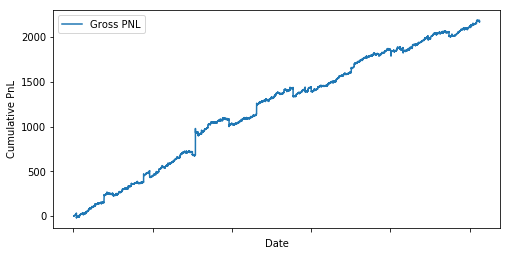

55.936836459890124


In [11]:
df.cumpnl.plot(label='Gross PNL', figsize=(8,4))  
plt.xlabel('Date')  
plt.ylabel('Cumulative PnL')  
plt.legend()  
plt.show()
print(2174.459585
/3887.348163779713*100)

In [12]:
a=df['pnl'].mean()

In [13]:
b=df['pnl'].std()

In [14]:
a/b*301.2

7.411333444469876

In [15]:
cnt=0
for i in range(1,len(df.index)):
    if df.loc[df.index[i],'positions']!=df.loc[df.index[i-1],'positions']:
        cnt+=1

In [16]:
cnt

3023

In [19]:
(df['HDFCB'].mean()+model.params[0]*df['HDFC'].mean())*cnt*0.02/100

2226.009989024216

In [20]:
(2174.459585
-2226.1)/3887.348163779713*100

-1.3284226887922814

In [21]:
df.to_csv('HDFCB_backtest.csv')